In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math
from numpy.random import seed
import json
from google.colab import drive
import IPython
import sys
import vertexai
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report
from vertexai.generative_models import GenerationConfig, GenerativeModel

In [ ]:
#!pip install tensorflow==2.15.1
# %pip install google-cloud-aiplatform --upgrade -q
# %pip install "bigframes<1.0.0" -q
# %pip install pandas==2.2.2
# %pip install scikit-learn -q

In [ ]:
# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

In [ ]:
PROJECT_ID = "your-project-id"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

vertexai.init(project=PROJECT_ID, location=LOCATION)

# IMDB Task

In [ ]:
seed(12102024)
tf.random.set_seed(12102024)

In [ ]:
# Downloand imdb data
imdb = keras.datasets.imdb
num_words = 20000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(seed=1, num_words=num_words)

In [ ]:
# A dictionary mapping words to an integer index
vocabulary = imdb.get_word_index()

# The first indices are reserved
vocabulary = {k:(v+3) for k,v in vocabulary.items()}
vocabulary["<PAD>"] = 0
# See how integer 1 appears first in the review above.
vocabulary["<START>"] = 1
vocabulary["<UNK>"] = 2  # unknown
vocabulary["<UNUSED>"] = 3

# reversing the vocabulary.
# in the index, the key is an integer,
# and the value is the corresponding word.
index = dict([(value, key) for (key, value) in vocabulary.items()])

def decode_review(text):
    '''converts encoded text to human readable form.
    each integer in the text is looked up in the index, and
    replaced by the corresponding word.
    '''
    return ' '.join([index.get(i, '?') for i in text])

In [ ]:
decode_review(train_data[0])

"<START> i have copy of this on vhs i think they the television networks should play this every year for the next twenty years so that we don't forget what was and that we remember not to do the same mistakes again like putting some people in the director's chair where they don't belong this movie <UNK> is like a <UNK> musical for those who can't sing or act this movie is as much fun as trying to teach the <UNK> to drive a city bus br br john hood <UNK> has just got out of prison and he's headed back to the old neighborhood in serving time for an all to nice crime of necessity of course john heads back onto the old street and is greeted by kids dogs old ladies and his peer <UNK> as they dance and sing all along the way br br i would recommend this if i was sentimental or if in truth someone was smoking <UNK> pot <UNK> by a doctor for <UNK> either way this is a poorly directed scripted acted and even produced i never thought i'd sat that satire of ghetto life with the <UNK> although i t

In [ ]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=vocabulary["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=vocabulary["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [ ]:
model = keras.Sequential()

# the first layer is the embedding layer.
# we indicate the number of possible words,
# the dimension of the embedding space,
# and the maximum size of the text.
model.add(keras.layers.Embedding(len(vocabulary), 2, input_length=256))

# the output of the embedding is multidimensional,
# with shape (256, 2)
# for each word, we obtain two values,
# the x and y coordinates
# we flatten this output to be able to
# use it in a dense layer
model.add(keras.layers.Flatten())

# dropout regularization
model.add(keras.layers.Dropout(rate=0.5))

# small dense layer. It's role is to analyze
# the distribution of points from embedding
model.add(keras.layers.Dense(5))

# final neuron, with sigmoid activation
# for binary classification
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 2)            177176    
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 5)                 2565      
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 179747 (702.14 KB)
Trainable params: 179747 (702.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_data,
                    train_labels,
                    epochs=10,
                    batch_size=100,
                    validation_data=(test_data, test_labels),
                    verbose=1)

Epoch 1/10
250/250 [==============================] - 60s 229ms/step - loss: 0.6829 - accuracy: 0.5583 - val_loss: 0.6225 - val_accuracy: 0.7086
Epoch 2/10
250/250 [==============================] - 36s 145ms/step - loss: 0.4389 - accuracy: 0.8092 - val_loss: 0.3401 - val_accuracy: 0.8596
Epoch 3/10
250/250 [==============================] - 17s 67ms/step - loss: 0.2941 - accuracy: 0.8814 - val_loss: 0.2984 - val_accuracy: 0.8784
Epoch 4/10
250/250 [==============================] - 10s 41ms/step - loss: 0.2443 - accuracy: 0.9024 - val_loss: 0.3026 - val_accuracy: 0.8708
Epoch 5/10
250/250 [==============================] - 11s 43ms/step - loss: 0.2151 - accuracy: 0.9146 - val_loss: 0.2876 - val_accuracy: 0.8817
Epoch 6/10
250/250 [==============================] - 9s 36ms/step - loss: 0.1908 - accuracy: 0.9250 - val_loss: 0.3059 - val_accuracy: 0.8717
Epoch 7/10
250/250 [==============================] - 5s 20ms/step - loss: 0.1776 - accuracy: 0.9302 - val_loss: 0.3017 - val_accuracy:

In [ ]:
def plot_accuracy(history, miny=None):
  acc = history.history['accuracy']
  test_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  plt.plot(epochs, acc)
  plt.plot(epochs, test_acc)
  if miny:
    plt.ylim(miny, 1.0)
  plt.title('accuracy')
  plt.xlabel('epoch')
  plt.figure()

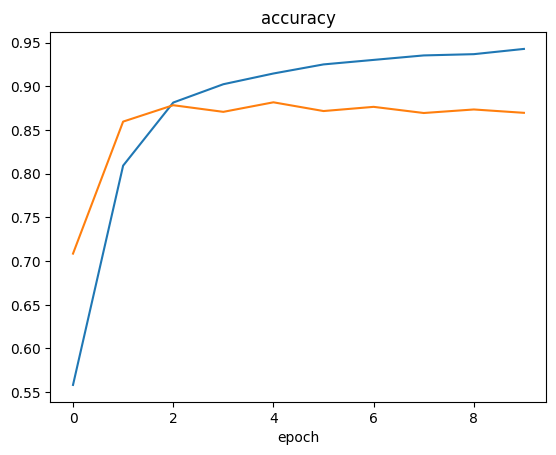

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_accuracy(history)

In [ ]:
get_embed_out = keras.backend.function(
    [model.layers[0].input],
    [model.layers[1].output])

In [ ]:
layer_output = get_embed_out([test_data[0:100,:]])
print(type(layer_output), len(layer_output), layer_output[0].shape)

<class 'list'> 1 (100, 512)


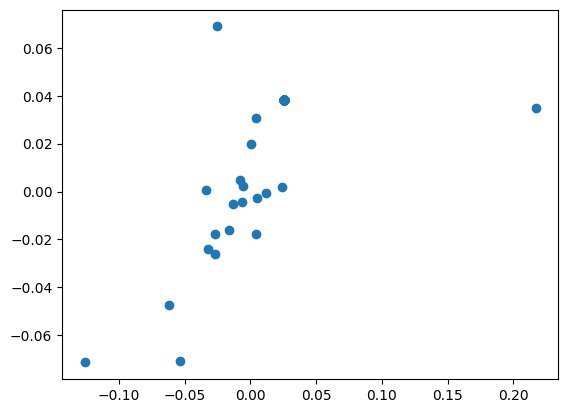

In [ ]:
words = layer_output[0]
plt.scatter(words[:,0], words[:,1])

In [ ]:
review = ['great', 'brilliant','crap','bad',
          'fantastic', 'movie', 'seagal']
enc_review = tf.constant([vocabulary[word] for word in review])
enc_review

<tf.Tensor: shape=(7,), dtype=int32, numpy=array([  87,  530,  595,   78,  777,   20, 3272], dtype=int32)>

In [ ]:
words = get_embed_out([enc_review])

In [ ]:
words = words[0]

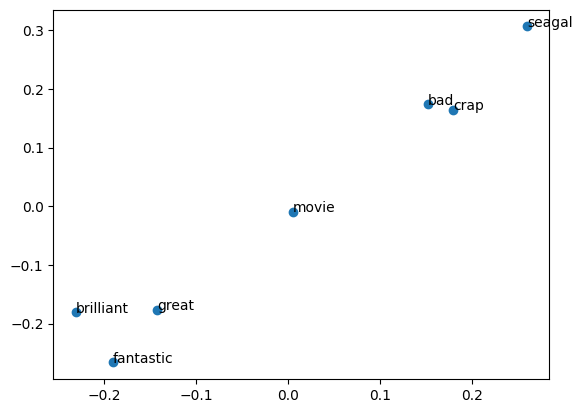

In [ ]:
plt.scatter(words[:,0], words[:,1])
for i, txt in enumerate(review):
    plt.annotate(txt, (words[i,0], words[i,1]))

In [ ]:
def plot_review(i):
    # plot the distribution of points
    enc_words = test_data[i]
    emb_words = get_embed_out([enc_words])[0]
    plt.figure(figsize=(8,8))
    plt.scatter(emb_words[:,0], emb_words[:,1])
    # use the label as title: 1 is positive,
    # 0 is negative
    plt.title(test_labels[i])
    # for words that are far enough from (0,0),
    # print the word
    for i, (enc_word, emb_word) in enumerate(zip(enc_words, emb_words)):
        word = index[enc_word]
        x, y = emb_word
        if math.sqrt(x**2 + y**2)>0.2:
            plt.annotate(word, (x, y))
    # fix the range in x and y to be able to compare
    # the distributions of different reviews
    axes = plt.gca()
    axes.set_xlim([-0.5,0.5])
    axes.set_ylim([-0.5, 0.5])
    axes.set_aspect('equal', adjustable='box')

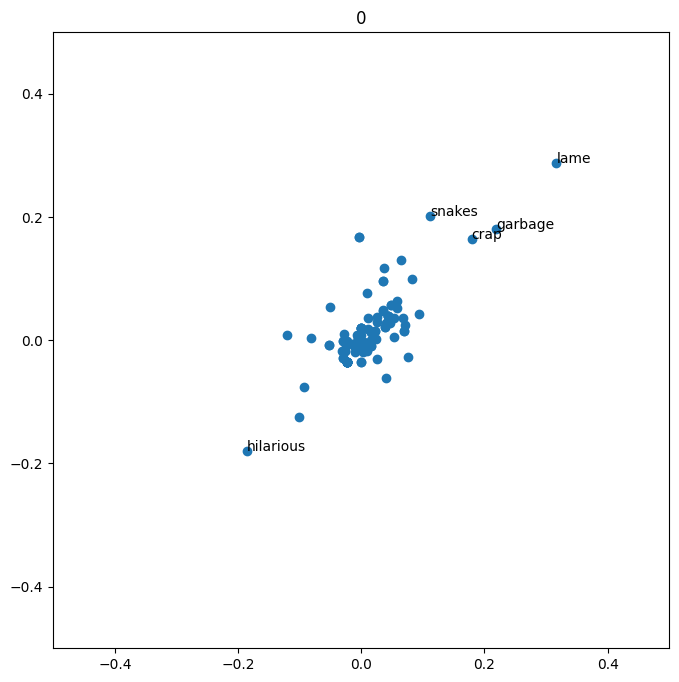

In [ ]:
plot_review(15)

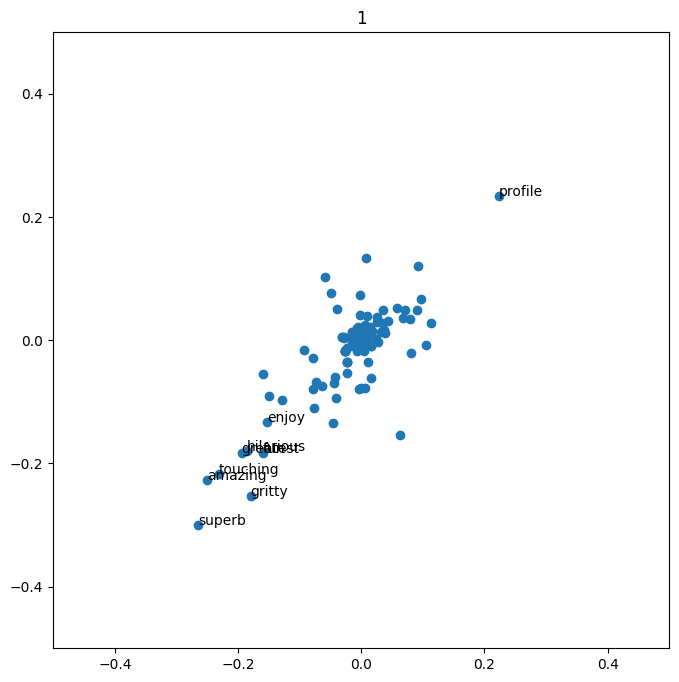

In [ ]:
plot_review(17)

# Data Management to construct test, train, and val set

In [ ]:
# Mount the data from my Google Drive to my current directory
# drive.mount('/content/drive')
!ls "/content/drive/My Drive/Data for CS 534"


Appliances.jsonl  Digital_Music.jsonl  Video_Games.jsonl


In [ ]:
music = pd.read_json(path_or_buf="/content/drive/My Drive/Data for CS 534/Digital_Music.jsonl", lines=True)
appliances = pd.read_json(path_or_buf="/content/drive/My Drive/Data for CS 534/Appliances.jsonl", lines=True)
games = pd.read_json(path_or_buf="/content/drive/My Drive/Data for CS 534/Video_Games.jsonl", lines=True)

In [ ]:
# Randomly shuffle database rows and select 200 from each rating for test data
# with the remaining data, 80/20 train/val split (computed a priori)

# Compute Masks for rating number
oneStarMusic = music['rating'] == 1
twoStarMusic = music['rating'] == 2
threeStarMusic = music['rating'] == 3
fourStarMusic = music['rating'] == 4
fiveStarMusic = music['rating'] == 5


# Shuffle using each mask
oneStarMusicShuf = music[oneStarMusic].sample(frac=1)
twoStarMusicShuf = music[twoStarMusic].sample(frac=1)
threeStarMusicShuf = music[threeStarMusic].sample(frac=1)
fourStarMusicShuf = music[fourStarMusic].sample(frac=1)
fiveStarMusicShuf = music[fiveStarMusic].sample(frac=1)

# Select 200 from each mask
test_oneStarMusic = oneStarMusicShuf[:200]
test_twoStarMusic = twoStarMusicShuf[:200]
test_threeStarMusic = threeStarMusicShuf[:200]
test_fourStarMusic = fourStarMusicShuf[:200]
test_fiveStarMusic = fiveStarMusicShuf[:200]
test_music = pd.concat([test_oneStarMusic, test_twoStarMusic, test_threeStarMusic, test_fourStarMusic, test_fiveStarMusic])
# Shuffle again
test_music = test_music.sample(frac=1)

# Using 80/20 split we compute the training data
train_oneStarMusic = oneStarMusicShuf[200:4949]
train_twoStarMusic = twoStarMusicShuf[200:2567]
train_threeStarMusic = threeStarMusicShuf[200:5154]
train_fourStarMusic = fourStarMusicShuf[200:11343]
train_fiveStarMusic = fiveStarMusicShuf[200:80534]
train_music = pd.concat([train_oneStarMusic, train_twoStarMusic, train_threeStarMusic, train_fourStarMusic, train_fiveStarMusic])
# Shuffle again
train_music = train_music.sample(frac=1)


val_oneStarMusic = oneStarMusicShuf[4949:]
val_twoStarMusic = twoStarMusicShuf[2567:]
val_threeStarMusic = threeStarMusicShuf[5154:]
val_fourStarMusic = fourStarMusicShuf[11343:]
val_fiveStarMusic = fiveStarMusicShuf[80534:]
val_music = pd.concat([val_oneStarMusic, val_twoStarMusic, val_threeStarMusic, val_fourStarMusic, val_fiveStarMusic])
# Shuffle again
val_music = val_music.sample(frac=1)


In [ ]:
# Randomly shuffle database rows and select 200 from each rating for test data
# with the remaining data, 80/20 train/val split (computed a priori)

# Compute Masks for rating number
oneStarApp = appliances['rating'] == 1
twoStarApp = appliances['rating'] == 2
threeStarApp = appliances['rating'] == 3
fourStarApp = appliances['rating'] == 4
fiveStarApp = appliances['rating'] == 5

# Shuffle using each mask
oneStarAppShuf = appliances[oneStarApp].sample(frac=1)
twoStarAppShuf = appliances[twoStarApp].sample(frac=1)
threeStarAppShuf = appliances[threeStarApp].sample(frac=1)
fourStarAppShuf = appliances[fourStarApp].sample(frac=1)
fiveStarAppShuf = appliances[fiveStarApp].sample(frac=1)

# Select 200 from each mask
test_oneStarApp = oneStarAppShuf[:200]
test_twoStarApp = twoStarAppShuf[:200]
test_threeStarApp = threeStarAppShuf[:200]
test_fourStarApp = fourStarAppShuf[:200]
test_fiveStarApp = fiveStarAppShuf[:200]
test_appliances = pd.concat([test_oneStarApp, test_twoStarApp, test_threeStarApp, test_fourStarApp, test_fiveStarApp])
test_appliances = test_appliances.sample(frac=1)

# Using 80/20 split we compute the training data
train_oneStarApp= oneStarAppShuf[200:200402]
train_twoStarApp = twoStarAppShuf[200:63771]
train_threeStarApp = threeStarAppShuf[200:83278]
train_fourStarApp = fourStarAppShuf[200:166613]
train_fiveStarApp = fiveStarAppShuf[200:1189020]
train_appliances = pd.concat([train_oneStarApp, train_twoStarApp, train_threeStarApp, train_fourStarApp, train_fiveStarApp])
train_appliances = train_appliances.sample(frac=1)


val_oneStarApp = oneStarAppShuf[200402:]
val_twoStarApp = twoStarAppShuf[63771:]
val_theeStarApp = threeStarAppShuf[83278:]
val_fourStarApp = fourStarAppShuf[166613:]
val_fiveStarApp = fiveStarAppShuf[1189020:]
val_appliances = pd.concat([val_oneStarApp, val_twoStarApp, val_theeStarApp, val_fourStarApp, val_fiveStarApp])

# Shuffle again
val_appliances = val_appliances.sample(frac=1)



In [ ]:
# Randomly shuffle database rows and select 200 from each rating for test data
# with the remaining data, 80/20 train/val split (computed a priori)

# Compute Masks for rating number
oneStarGames = games['rating'] == 1
twoStarGames = games['rating'] == 2
threeStarGames = games['rating'] == 3
fourStarGames = games['rating'] == 4
fiveStarGames = games['rating'] == 5

oneStarGamesShuf = games[oneStarGames].sample(frac=1)
twoStarGamesShuf = games[twoStarGames].sample(frac=1)
threeStarGamesShuf = games[threeStarGames].sample(frac=1)
fourStarGamesShuf = games[fourStarGames].sample(frac=1)
fiveStarGamesShuf = games[fiveStarGames].sample(frac=1)

test_oneStarGames = oneStarGamesShuf[:200]
test_twoStarGames = twoStarGamesShuf[:200]
test_threeStarGames = threeStarGamesShuf[:200]
test_fourStarGames = fourStarGamesShuf[:200]
test_fiveStarGames = fiveStarGamesShuf[:200]
test_games = pd.concat([test_oneStarGames, test_twoStarGames, test_threeStarGames, test_fourStarGames, test_fiveStarGames])
test_games = test_games.sample(frac=1)

train_oneStarGames = oneStarGamesShuf[200:471655]
train_twoStarGames = twoStarGamesShuf[200:199942]
train_threeStarGames = threeStarGamesShuf[200:272109]
train_fourStarGames = fourStarGamesShuf[200:493841]
train_fiveStarGames = fiveStarGamesShuf[200:2262345]
train_games = pd.concat([train_oneStarGames, train_twoStarGames, train_threeStarGames, train_fourStarGames, train_fiveStarGames])
train_games = train_games.sample(frac=1)


val_oneStarGames = oneStarGamesShuf[471655:]
val_twoStarGames = twoStarGamesShuf[199942:]
val_threeStarGames = threeStarGamesShuf[272109:]
val_fourStarGames = fourStarGamesShuf[493841:]
val_fiveStarGames = fiveStarGamesShuf[2262345:]
val_games = pd.concat([val_oneStarGames, val_twoStarGames, val_threeStarGames, val_fourStarGames, val_fiveStarGames])
val_games = val_games.sample(frac=1)

# Prompt-Based Task

In [ ]:
# Import Model
generation_model = GenerativeModel("gemini-1.5-pro")
generation_config = GenerationConfig(temperature=0.1, max_output_tokens=256)

## Zero-shot prompting

In [ ]:
prompt = """
Classify the following:\n
text: "I saw a furry animal in the park today with a long tail and big eyes."
label: dogs, cats
"""

response = generation_model.generate_content(
    contents=prompt, generation_config=generation_config
).text
print(response)

ERROR:grpc._plugin_wrapping:AuthMetadataPluginCallback "<google.auth.transport.grpc.AuthMetadataPlugin object at 0x79b2ee7b51e0>" raised exception!
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/credentials.py", line 128, in refresh
    self._retrieve_info(request)
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/credentials.py", line 101, in _retrieve_info
    info = _metadata.get_service_account_info(
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/_metadata.py", line 323, in get_service_account_info
    return get(request, path, params={"recursive": "true"})
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/_metadata.py", line 248, in get
    raise exceptions.TransportError(
google.auth.exceptions.TransportError: ("Failed to retrieve http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true from the Go

ServiceUnavailable: 503 Getting metadata from plugin failed with error: ("Failed to retrieve http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true from the Google Compute Engine metadata service. Status: 404 Response:\nb''", <google.auth.transport.requests._Response object at 0x79aefe228490>)

In [ ]:
prompt = """
What is the topic for a given news headline? \n
- business \n
- entertainment \n
- health \n
- sports \n
- technology \n\n

Text: Pixel 7 Pro Expert Hands On Review. \n
The answer is: technology \n

Text: Quit smoking? \n
The answer is: health \n

Text: Birdies or bogeys? Top 5 tips to hit under par \n
The answer is: sports \n

Text: Relief from local minimum-wage hike looking more remote \n
The answer is: business \n

Text: You won't guess who just arrived in Bari, Italy for the movie premiere. \n
The answer is:
"""

response = generation_model.generate_content(
    contents=prompt, generation_config=generation_config
).text
print(response)

ERROR:grpc._plugin_wrapping:AuthMetadataPluginCallback "<google.auth.transport.grpc.AuthMetadataPlugin object at 0x79b2ee7d8610>" raised exception!
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/credentials.py", line 128, in refresh
    self._retrieve_info(request)
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/credentials.py", line 101, in _retrieve_info
    info = _metadata.get_service_account_info(
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/_metadata.py", line 323, in get_service_account_info
    return get(request, path, params={"recursive": "true"})
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/_metadata.py", line 248, in get
    raise exceptions.TransportError(
google.auth.exceptions.TransportError: ("Failed to retrieve http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true from the Go

ServiceUnavailable: 503 Getting metadata from plugin failed with error: ("Failed to retrieve http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true from the Google Compute Engine metadata service. Status: 404 Response:\nb''", <google.auth.transport.requests._Response object at 0x79b2ee76b9a0>)

In [ ]:
review_data_df = pd.DataFrame(
    {
        "review": [
            "i love this product. it does have everything i am looking for!",
            "all i can say is that you will be happy after buying this product",
            "its way too expensive and not worth the price",
            "i am feeling okay. its neither good nor too bad.",
        ],
        "sentiment_groundtruth": ["positive", "positive", "negative", "neutral"],
    }
)

In [ ]:
def get_sentiment(row):
    prompt = f"""Classify the sentiment of the following review as "positive", "neutral" and "negative". \n\n
                review: {row} \n
                sentiment:
              """
    response = generation_model.generate_content(
        contents=prompt, generation_config=generation_config
    ).text
    return response


review_data_df["sentiment_prediction"] = review_data_df["review"].apply(get_sentiment)
review_data_df

ERROR:grpc._plugin_wrapping:AuthMetadataPluginCallback "<google.auth.transport.grpc.AuthMetadataPlugin object at 0x79b2ee7d8610>" raised exception!
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/credentials.py", line 128, in refresh
    self._retrieve_info(request)
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/credentials.py", line 101, in _retrieve_info
    info = _metadata.get_service_account_info(
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/_metadata.py", line 323, in get_service_account_info
    return get(request, path, params={"recursive": "true"})
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/_metadata.py", line 248, in get
    raise exceptions.TransportError(
google.auth.exceptions.TransportError: ("Failed to retrieve http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true from the Go

ServiceUnavailable: 503 Getting metadata from plugin failed with error: ("Failed to retrieve http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true from the Google Compute Engine metadata service. Status: 404 Response:\nb''", <google.auth.transport.requests._Response object at 0x79aefe22a3b0>)

In [ ]:
report = classification_report(
    review_data_df["sentiment_groundtruth"], review_data_df["sentiment_prediction"]
)
print(report)

KeyError: 'sentiment_prediction'

# BERT

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

In [ ]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id
tokenizer.cls_token, tokenizer.cls_token_id
tokenizer.pad_token, tokenizer.pad_token_id
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [ ]:
token_lens = []

for txt in train_appliances:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

KeyboardInterrupt: 

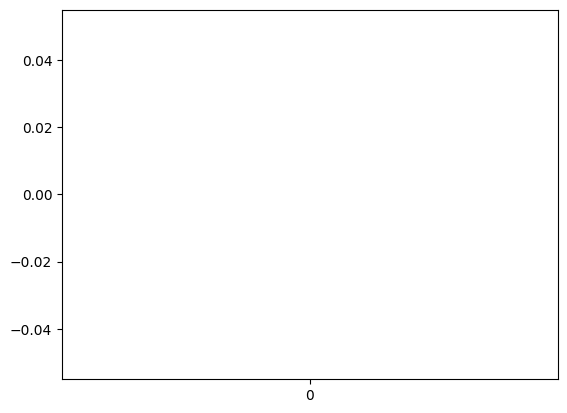

In [ ]:
sn.countplot(train_appliances.rating)
plt.xlabel('review score');

In [ ]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2

test['sentiment'] = df.score.apply(to_sentiment)

NameError: name 'df' is not defined

In [ ]:
class_names = ['negative', 'neutral', 'positive']

In [ ]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

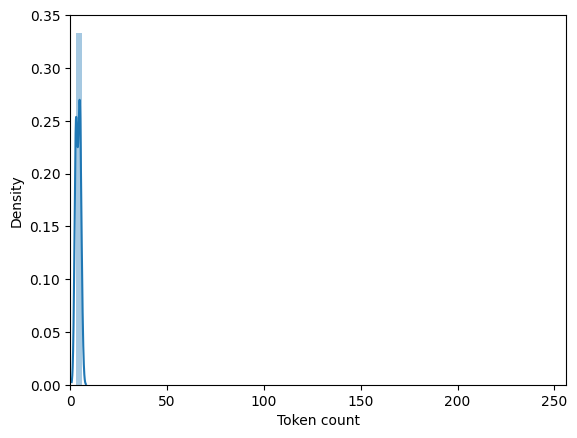

In [ ]:
sn.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');